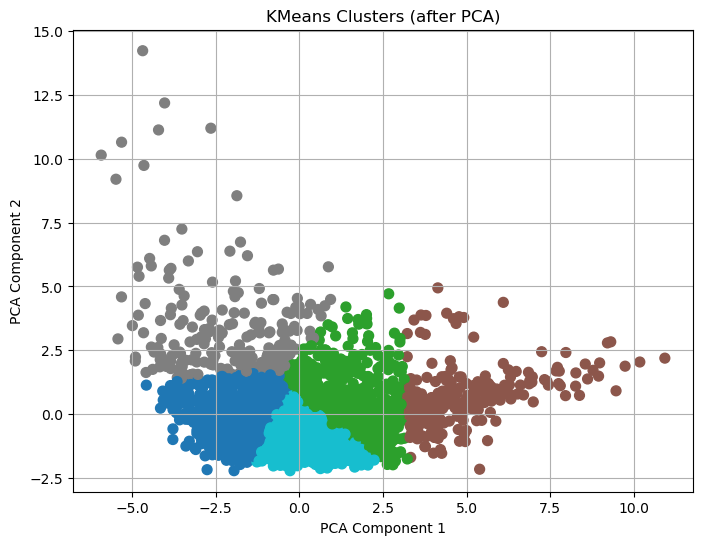

Explained variance ratio:
[0.31792753 0.14131082]

PCA Loadings:
                                                       PC1       PC2
Percentage_Obesity                                0.315020 -0.240546
Preterm Births (%) 2020-2022                      0.359220  0.014054
Low Birth Weight (%) 2020-2022                    0.356895  0.121123
Infant Mortality Rate (per 1,000) 2020-2022       0.280854 -0.099116
Percent with SNAP                                 0.354799  0.004957
Bachelor's degree or higher                      -0.278077  0.287761
Family Medicine Provider Rate (per 100,000)      -0.144762  0.034024
Black or African American alone                   0.310263  0.194277
Hispanic or Latino                                0.007230  0.389737
All people in poverty                             0.378815  0.037074
2023.0                                            0.188351  0.075764
Per 1,000 women 15 to 50 years old                0.015606 -0.091913
Civilian veterans                     

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

##Read in the dataset 
complete = pd.read_csv("county_census_snap_data.csv")

##Create a dataframe that only includes columns you need most

data = {
    'Percentage_Obesity': complete["Percentage_Obesity"].values,
    'Preterm Births (%) 2020-2022': complete["Preterm Births (%) 2020-2022"].values,
    'Low Birth Weight (%) 2020-2022': complete["Low Birth Weight (%) 2020-2022"].values, 
    'Infant Mortality Rate (per 1,000) 2020-2022': complete["Infant Mortality Rate (per 1,000) 2020-2022"].values,
    'Percent with SNAP': complete["Percent with SNAP"],
    "Bachelor's degree or higher": complete["Bachelor's degree or higher"],
    "Family Medicine Provider Rate (per 100,000)": complete["Family Medicine Provider Rate (per 100,000)"],
    "Black or African American alone": complete["Black or African American alone"],
    "Hispanic or Latino": complete["Hispanic or Latino"],
    "All people in poverty": complete["All people in poverty"],
    "2023.0": complete["2023.0"],
    "Per 1,000 women 15 to 50 years old": complete["Per 1,000 women 15 to 50 years old"],
    "Civilian veterans": complete["Civilian veterans"],
    "White alone": complete["White alone"],
    "Asian alone": complete["Asian alone"],
    "Native Hawaiian and Other Pacific Islander alone": complete["Native Hawaiian and Other Pacific Islander alone"]
}

variables = pd.DataFrame(data)

##Create a scaled dataframe to perform the kmeans clustering on
scaler = StandardScaler()
variables_scaled = scaler.fit_transform(variables)
variables_scaled = pd.DataFrame(variables_scaled)
variables_scaled.rename(columns={
    0: 'Percentage_Obesity',
    1: 'Preterm Births (%) 2020-2022',
    2: 'Low Birth Weight (%) 2020-2022',
    3: 'Infant Mortality Rate (per 1,000) 2020-2022',
    4: 'Percent with SNAP',
    5: "Bachelor's degree or higher",
    6: "Family Medicine Provider Rate (per 100,000)",
    7: "Black or African American alone",
    8: "Hispanic or Latino",
    9: "All people in poverty",
    10: "2023.0",
    11: "Per 1,000 women 15 to 50 years old",
    12: "Civilian veterans",
    13: "White alone",
    14: "Asian alone",
    15: "Native Hawaiian and Other Pacific Islander alone"
}, inplace=True)


# Step 1: Apply PCA (on scaled variables)

pca = PCA(n_components=2)
variables_2d = pca.fit_transform(variables_scaled)

# Step 2: Run KMeans on PCA-reduced data
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(variables_2d)

# Step 3: Store cluster labels
complete['Cluster'] = kmeans.labels_

# Step 4: Visualize clusters in PCA space
plt.figure(figsize=(8,6))
plt.scatter(variables_2d[:, 0], variables_2d[:, 1], c=complete['Cluster'], cmap='tab10', s=50)
plt.title('KMeans Clusters (after PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Step 5: Show variance explained by each component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

# Step 6: Loadings (optional – helps interpret PCA axes)
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=variables_scaled.columns)

print("\nPCA Loadings:")
print(loadings)

##Find the center of each cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['PC1', 'PC2'])
print(cluster_centers)


In [113]:

complete['State'] = complete['label'].str.split(', ').str[-1]

southern = ['Texas', 'Oklahoma', 'Arkansas', 'Louisiana', 'Mississippi', 'Alabama', 'Georgia', 'Florida', 'South Carolina', 'Tennessee', 'North Carolina', 'Kentucky', 'Virginia', 'West Virginia', 'Maryland', 'Delaware', 'District of Columbia']
northeast = ['Pennsylvania', 'New Jersey', 'New York', 'Connecticut', 'Massachusetts', 'Rhode Island', 'Vermont', 'New Hampshire', 'Maine']
midwest = ['Kansas', 'Missouri', 'Illinois', 'Indiana', 'Ohio', 'Michigan', 'Wisconsin', 'Iowa', 'Nebraska', 'South Dakota', 'Minnesota', 'North Dakota']
west = ['New Mexico', 'Colorado', 'Utah', 'Arizona', 'Nevada', 'Wyoming', 'Idaho', 'Montana', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']

# Combine all into a single mapping
state_to_region = {}

for state in southern:
    state_to_region[state] = 'South'
for state in northeast:
    state_to_region[state] = 'Northeast'
for state in midwest:
    state_to_region[state] = 'Midwest'
for state in west:
    state_to_region[state] = 'West'

complete['Region'] = complete['State'].map(state_to_region)

In [114]:
# Step 7: Convert PCA cluster centers back to original variable space

# (a) Back to scaled 6D space (undo PCA)
centers_scaled = pca.inverse_transform(kmeans.cluster_centers_)

# (b) Back to original units (undo standard scaling)
centers_original = scaler.inverse_transform(centers_scaled)

# (c) Turn into readable DataFrame
cluster_centers_original = pd.DataFrame(centers_original, columns=variables.columns)

print("\nCluster Centers (Original Feature Space):")
print(cluster_centers_original.round(2))



Cluster Centers (Original Feature Space):
   Percentage_Obesity  Preterm Births (%) 2020-2022  \
0               35.47                          9.58   
1               39.48                         11.85   
2               44.19                         14.02   
3               30.85                          9.46   
4               39.03                         10.83   

   Low Birth Weight (%) 2020-2022  \
0                            7.27   
1                            9.70   
2                           11.86   
3                            7.88   
4                            8.38   

   Infant Mortality Rate (per 1,000) 2020-2022  Percent with SNAP  \
0                                         5.34               0.10   
1                                         7.13               0.18   
2                                         9.00               0.26   
3                                         4.40               0.09   
4                                         6.59            

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


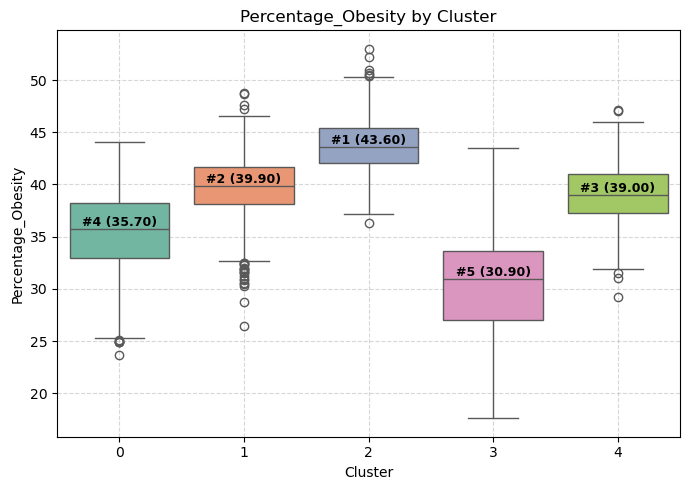

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


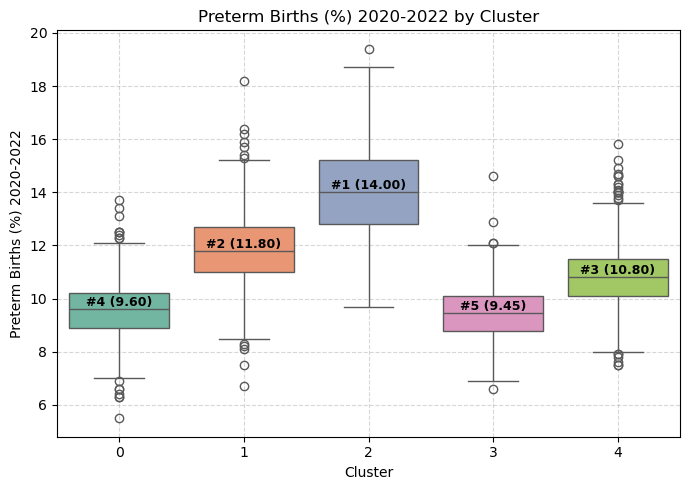

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


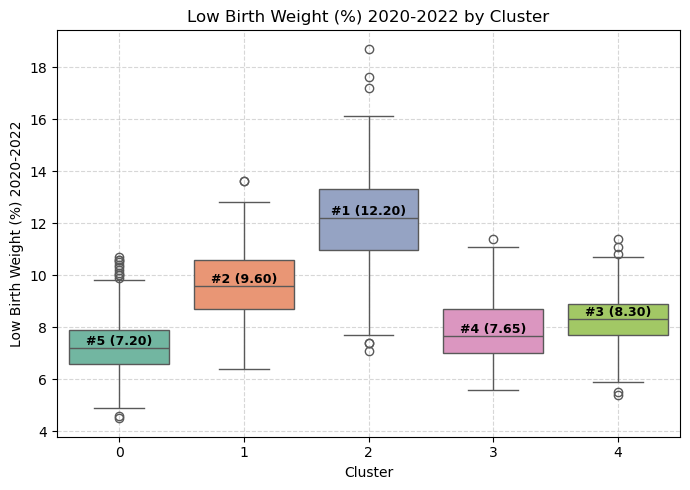

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


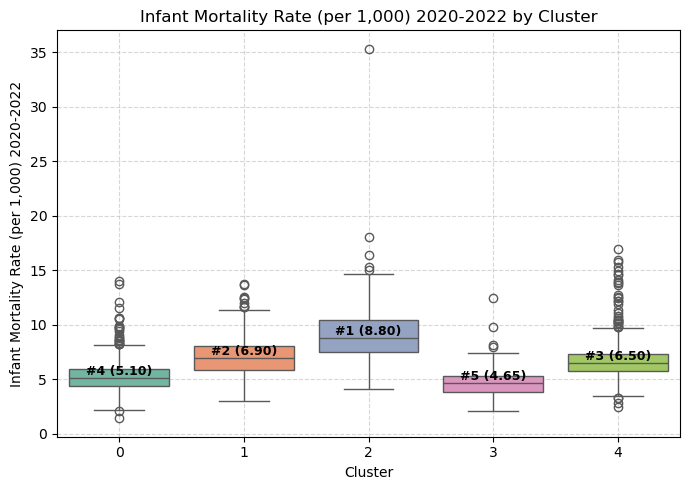

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


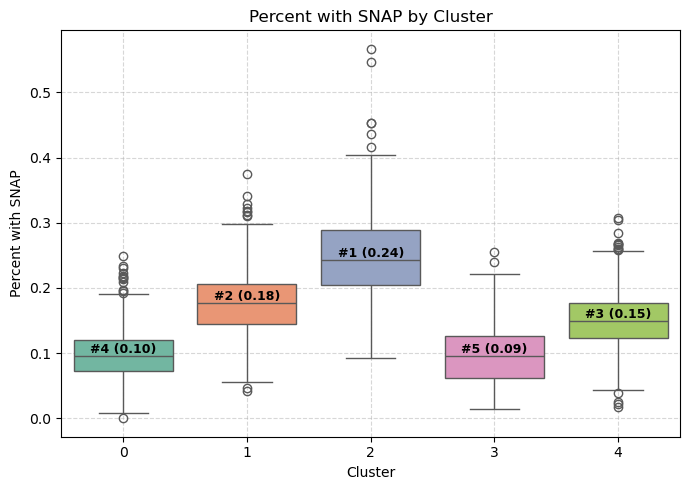

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


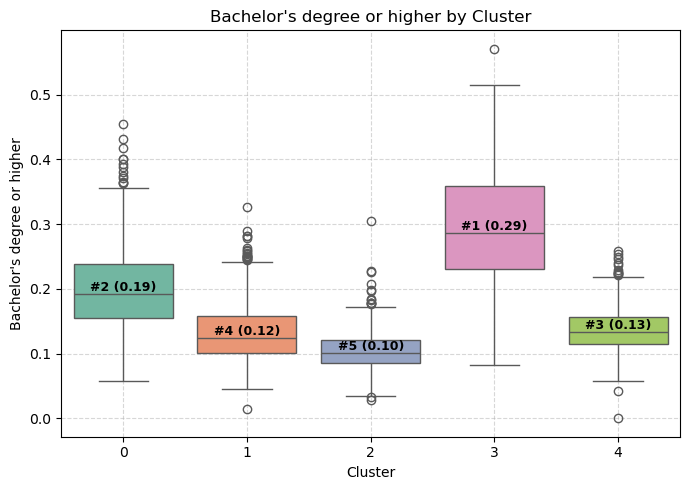

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


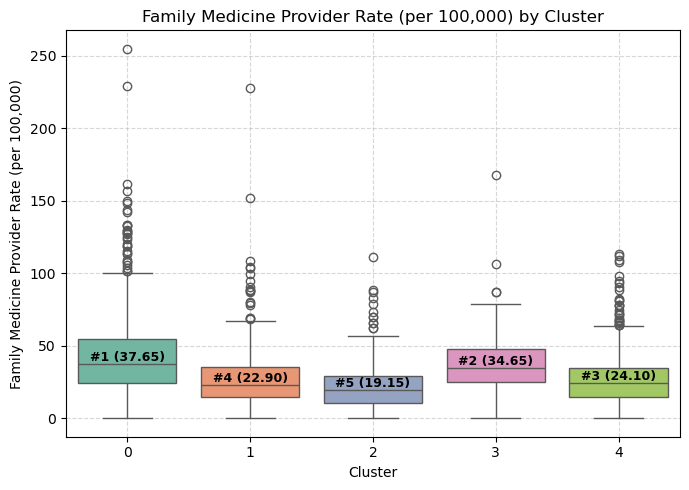

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


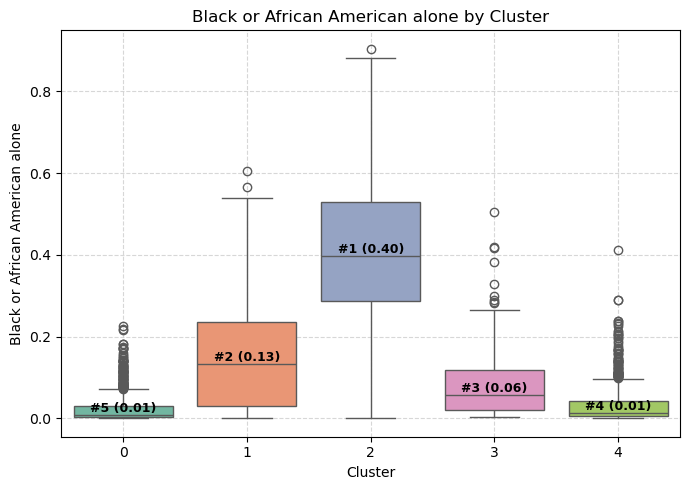

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


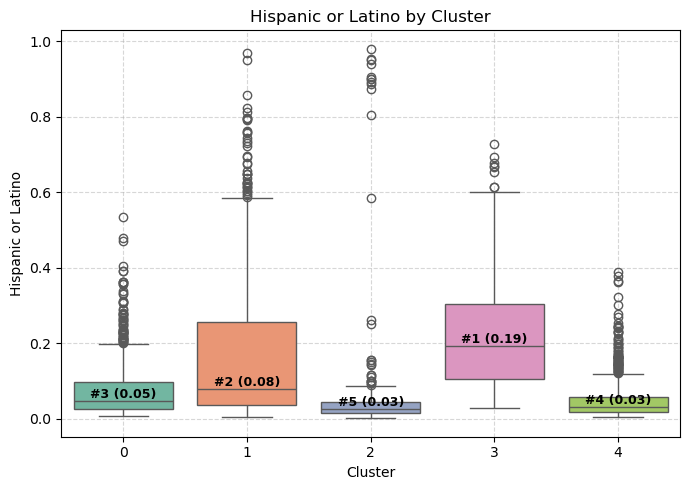

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


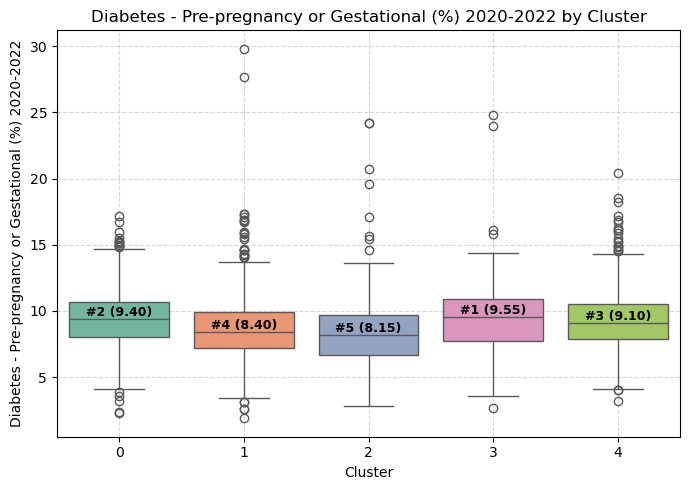

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


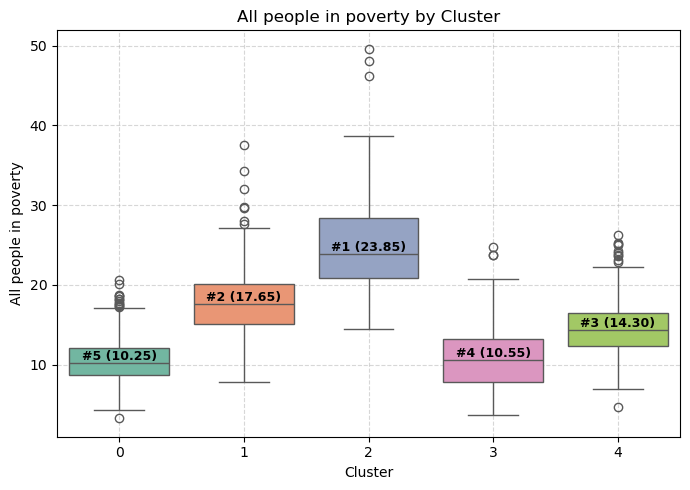

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


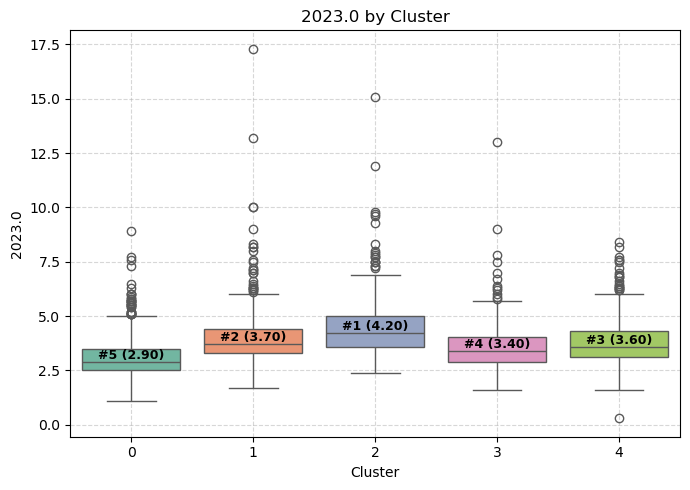

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


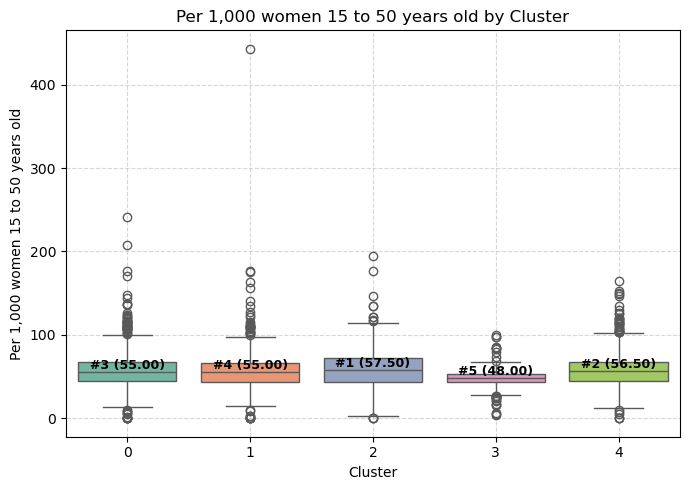

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


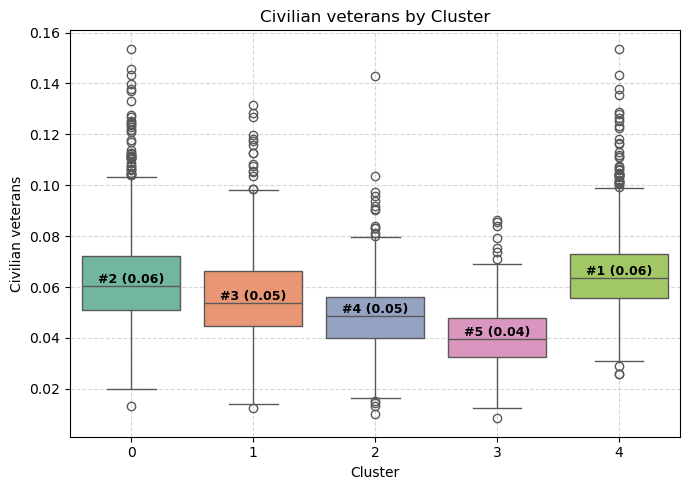

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


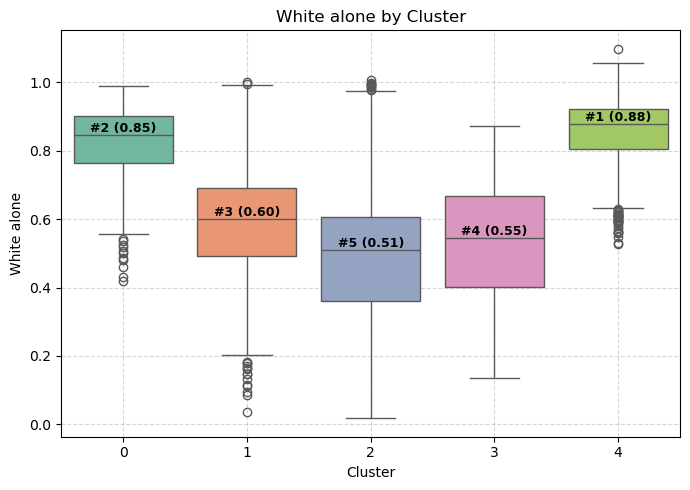

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


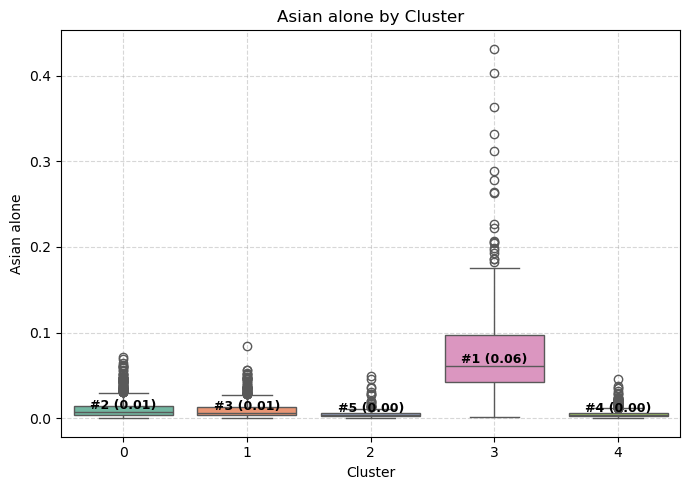

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/224474683.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')


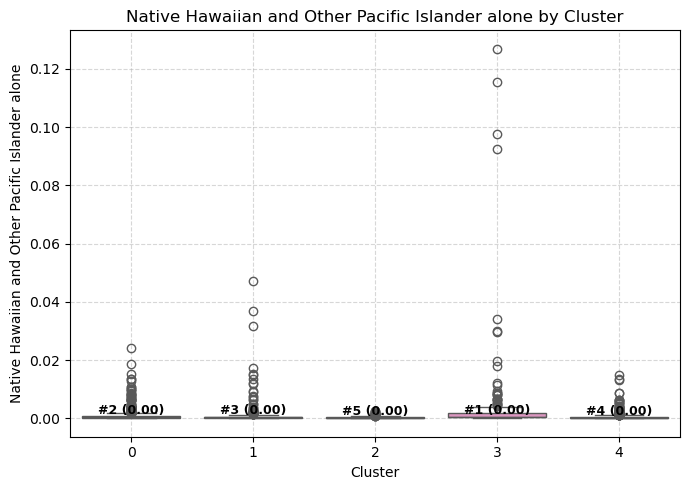

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of original variable names
variables_list = [
    'Percentage_Obesity',
    'Preterm Births (%) 2020-2022',
    'Low Birth Weight (%) 2020-2022',
    'Infant Mortality Rate (per 1,000) 2020-2022',
    'Percent with SNAP',
    "Bachelor's degree or higher",
    "Family Medicine Provider Rate (per 100,000)",
    "Black or African American alone",
    "Hispanic or Latino",
    "Diabetes - Pre-pregnancy or Gestational (%) 2020-2022",
    "All people in poverty",
    "2023.0",
    "Per 1,000 women 15 to 50 years old",
    "Civilian veterans",
    "White alone",
    "Asian alone",
    "Native Hawaiian and Other Pacific Islander alone"

]

# Loop through each variable and create a boxplot
for var in variables_list:
    plt.figure(figsize=(7, 5))
    ax = sns.boxplot(x='Cluster', y=var, data=complete, palette='Set2')
    
    # Add median labels
    #medians = complete.groupby('Cluster')[var].median()
    #for i, median in enumerate(medians):
        #ax.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')
    
    # Calculate medians
    medians = complete.groupby('Cluster')[var].median()

    # Rank clusters by median (highest = #1)
    ranked = medians.sort_values(ascending=False)
    ranks = {cluster: f'#{rank+1}' for rank, cluster in enumerate(ranked.index)}

    # Plot median values and rank labels
    for i, median in enumerate(medians):
        rank_label = ranks[i]
        ax.text(i, median, f'{rank_label} ({median:.2f})', 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    plt.title(f'{var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [116]:
complete['County'] = complete['label'].str.split(',').str[0]         # "Autauga County"
complete['County'] = complete['County'].str.replace('County', '').str.strip()  # Remove "County"

# Downloaded pre-built file, e.g., from GitHub Gist
coords = pd.read_csv("us_county_latlng.csv")    # columns: fips_code, name, lat, lng

# Normalize columns for merging
coords = coords.rename(columns={"name": "County", "lng": "lon", "fips_code":"FIPS"})

complete = complete.merge(coords[['County','lat','lon']], on='County', how='left')


In [117]:
##Creating a column to classify the type of area you are in 

for index, row in complete.iterrows():
    if row["NCHS Urban-Rural Classification_Large fringe metro"] == 1:
        complete.at[index, "Area Class"] = "Large fringe metro"
    elif row["NCHS Urban-Rural Classification_Medium metro"] == 1:
        complete.at[index, "Area Class"] = "Medium metro"   
    elif row["NCHS Urban-Rural Classification_Micropolitan"] == 1:
        complete.at[index, "Area Class"] = "Micropolitan"
    elif row["NCHS Urban-Rural Classification_Non-core"] == 1:
        complete.at[index, "Area Class"] = "Non-core"
    elif row["NCHS Urban-Rural Classification_Small metro"] == 1:
        complete.at[index, "Area Class"] = "Small metro"

complete['color_codes'] = complete['Area Class'].astype('category').cat.codes

In [118]:
cluster0 = complete[complete['Cluster']==0]
cluster1 = complete[complete['Cluster']==1]
cluster2 = complete[complete['Cluster']==2]
cluster3 = complete[complete['Cluster']==3]
cluster4 = complete[complete['Cluster']==4]

/var/folders/qn/pr1whzk53j13xb8ckndcf06c0000gn/T/ipykernel_84309/2780339526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster1['color_codes'] = color_codes


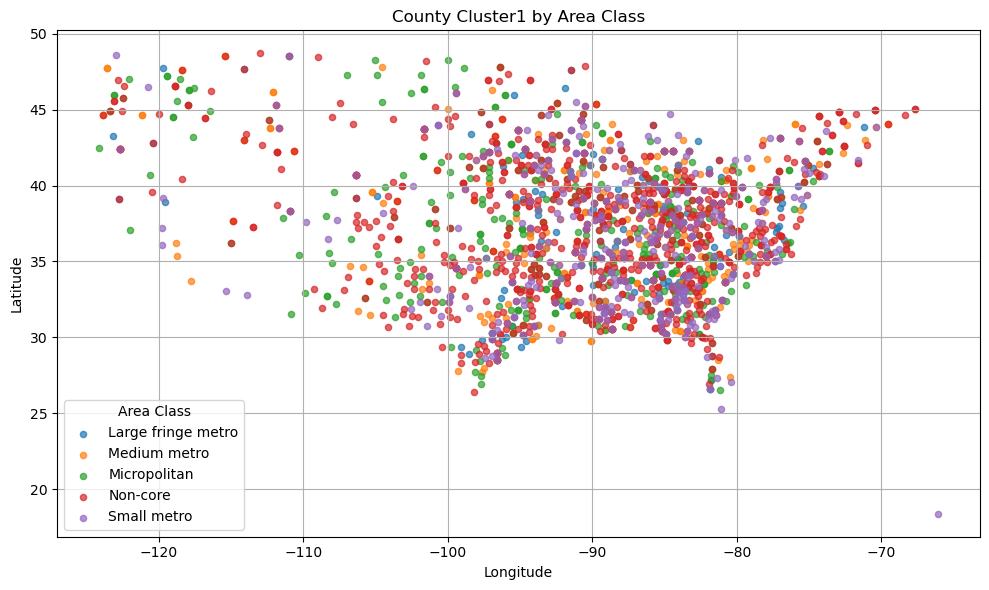

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Get unique area classes and their colors
area_classes = cluster1['Area Class'].astype('category')
categories = area_classes.cat.categories
color_codes = area_classes.cat.codes
cluster1['color_codes'] = color_codes

# Plot each area class separately so we can label them in the legend
for code, category in enumerate(categories):
    subset = cluster1[cluster1['color_codes'] == code]
    plt.scatter(
        subset['lon'],
        subset['lat'],
        c=[plt.cm.tab10(code)],  # Get color from colormap
        label=category,
        s=20,
        alpha=0.7
    )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('County Cluster1 by Area Class')
plt.grid(True)
plt.legend(title='Area Class', loc='best')
plt.tight_layout()
plt.show()


In [120]:
percentages = (
    complete.groupby('Cluster')["Area Class"]
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

print(percentages.round(2))

Area Class  Large fringe metro  Medium metro  Micropolitan  Non-core  \
Cluster                                                                
0                        15.20         12.33         20.37     37.43   
1                         7.10         16.17         19.32     41.37   
2                         2.43          7.78         19.69     61.99   
3                        62.31         19.79          4.65      3.27   
4                         9.48         10.18         27.11     43.65   

Area Class  Small metro  
Cluster                  
0                 14.67  
1                 16.04  
2                  8.10  
3                  9.98  
4                  9.58  


In [122]:
percentages1 = (
    complete.groupby('Cluster')["Region"]
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

print(percentages1.round(2))

Region   Midwest  Northeast  South   West
Cluster                                  
0          49.14      14.15  16.55  20.16
1          12.49       0.42  79.47   7.61
2           2.25       0.24  97.11   0.40
3          19.13      21.24  31.65  27.99
4          46.83       6.03  44.47   2.67
